# Cal-CRAI Index: Equal-Weighting Climate Risk

**Order of operations**:
1) Metric handling
   - Retrieve & clean data
   - Merge data domains together
   - Calculate domain medians and adjusted scores
   - Pull climate domain and clean & merge
2) Calculate index
3) Visualize index results
4) Bin values into 5 sections based on equal percentiles
   - Visualize
5) Export data as a GeoDataBase and upload to AWS

In [57]:
import pandas as pd
import os
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import fiona
import shutil

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.calculate_index import calculate_equal_weighted_index, add_census_tracts
from scripts.utils.index_plots import index_plot, plot_region_domain

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data'
output_folder = 'aws_csvs'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data.


In [3]:
built_domain = pd.read_csv(r'aws_csvs/built_domain_index_calculation.csv')
governance_domain = pd.read_csv(r'aws_csvs/governance_domain_index_calculation.csv')
natural_domain = pd.read_csv(r'aws_csvs/natural_domain_index_calculation.csv')
society_domain = pd.read_csv(r'aws_csvs/society_economy_domain_index_calculation.csv')
climate_domain = pd.read_csv(r'aws_csvs/climate_domain_index_calculation.csv')

In [4]:
# Keep only the first two columns
built_domain_cleaned = built_domain.iloc[:, :2]
governance_domain_cleaned = governance_domain.iloc[:, :2]
natural_domain_cleaned = natural_domain.iloc[:, :2]
society_domain_cleaned = society_domain.iloc[:, :2]
climate_domain_cleaned = climate_domain.iloc[:, :2]

### 1b) Merge data domains together

In [5]:
merged_domains = pd.merge(governance_domain_cleaned, built_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, natural_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, society_domain_cleaned, on='GEOID', how='left')

In [6]:
# Ensure all values in GEOID are strings
merged_domains['GEOID'] = merged_domains['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
merged_domains['GEOID'] = merged_domains['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max() + 1)

# Rename the standardized columns for simplicity
merged_domains = merged_domains.rename(columns={
    'summed_indicators_governance_domain_min_max_standardized':'governance_domain_index',
    'summed_indicators_built_domain_min_max_standardized':'built_domain_index',
    'summed_indicators_natural_domain_min_max_standardized':'natural_systems_domain_index', 
    'summed_indicators_society_economy_domain_min_max_standardized':'society_economy_domain_index'     
})

# Display the dataframe
merged_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index
0,06001400100,0.651308,0.605062,0.518637,0.833488
1,06001400200,0.651308,0.553534,0.366578,0.841855
2,06001400300,0.651308,0.557473,0.338360,0.793298
3,06001400400,0.651308,0.549355,0.358216,0.770451
4,06001400500,0.651308,0.552923,0.367882,0.744977
...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342
9125,06115041001,0.682143,0.416459,0.466137,0.742681
9126,06115041002,0.682143,0.432561,0.584687,0.766956
9127,06115041101,0.682143,0.391202,0.683639,0.736324


### 1c) Calculate data domain median and adjusted columns

In [7]:
all_domains = merged_domains.copy()
all_domains['built_median'] = merged_domains['built_domain_index'].median()
all_domains['natural_systems_median'] = merged_domains['natural_systems_domain_index'].median()
all_domains['society_economy_median'] = merged_domains['society_economy_domain_index'].median()

all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median
0,06001400100,0.651308,0.605062,0.518637,0.833488,0.642475,0.451652,0.748805
1,06001400200,0.651308,0.553534,0.366578,0.841855,0.642475,0.451652,0.748805
2,06001400300,0.651308,0.557473,0.338360,0.793298,0.642475,0.451652,0.748805
3,06001400400,0.651308,0.549355,0.358216,0.770451,0.642475,0.451652,0.748805
4,06001400500,0.651308,0.552923,0.367882,0.744977,0.642475,0.451652,0.748805
...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342,0.642475,0.451652,0.748805
9125,06115041001,0.682143,0.416459,0.466137,0.742681,0.642475,0.451652,0.748805
9126,06115041002,0.682143,0.432561,0.584687,0.766956,0.642475,0.451652,0.748805
9127,06115041101,0.682143,0.391202,0.683639,0.736324,0.642475,0.451652,0.748805


In [8]:
def calculate_adjusted_value(row, category):
    category_median_col = f'{category}_median'
    category_col = f'{category}_domain_index'
    adjusted_col = f'{category}_tract_adjusted'
    return (row[category_col] - row[category_median_col]) / row[category_median_col]

# Loop through each row and calculate the adjusted value for each category
for index, row in all_domains.iterrows():
    for category in ['natural_systems', 'society_economy', 'built']:
        adjusted_value = calculate_adjusted_value(row, category)
        adjusted_col = f'{category}_tract_adjusted'
        all_domains.at[index, adjusted_col] = adjusted_value

# Display the DataFrame
all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted
0,06001400100,0.651308,0.605062,0.518637,0.833488,0.642475,0.451652,0.748805,0.148310,0.113091,-0.058232
1,06001400200,0.651308,0.553534,0.366578,0.841855,0.642475,0.451652,0.748805,-0.188363,0.124264,-0.138434
2,06001400300,0.651308,0.557473,0.338360,0.793298,0.642475,0.451652,0.748805,-0.250839,0.059419,-0.132304
3,06001400400,0.651308,0.549355,0.358216,0.770451,0.642475,0.451652,0.748805,-0.206877,0.028908,-0.144939
4,06001400500,0.651308,0.552923,0.367882,0.744977,0.642475,0.451652,0.748805,-0.185476,-0.005111,-0.139386
...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342,0.642475,0.451652,0.748805,0.044468,0.046124,-0.270099
9125,06115041001,0.682143,0.416459,0.466137,0.742681,0.642475,0.451652,0.748805,0.032071,-0.008179,-0.351789
9126,06115041002,0.682143,0.432561,0.584687,0.766956,0.642475,0.451652,0.748805,0.294550,0.024240,-0.326726
9127,06115041101,0.682143,0.391202,0.683639,0.736324,0.642475,0.451652,0.748805,0.513641,-0.016668,-0.391102


## 1d) Pull climate domain and clean & merge

In [9]:
climate_domain_cleaned

,GEOID,all_domain_loss_exposure_product_min_max_standardized
0,6001400100,0.753671
1,6001400200,0.704640
2,6001400300,0.764024
3,6001400400,0.702309
4,6001400500,0.781995
...,...,...
9124,6115040902,0.409434
9125,6115041001,0.382023
9126,6115041002,0.396227
9127,6115041101,0.361174


In [10]:
# Ensure all values in GEOID are strings
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max())

# Display the dataframe
climate_domain_cleaned

,GEOID,all_domain_loss_exposure_product_min_max_standardized
0,06001400100,0.753671
1,06001400200,0.704640
2,06001400300,0.764024
3,06001400400,0.702309
4,06001400500,0.781995
...,...,...
9124,06115040902,0.409434
9125,06115041001,0.382023
9126,06115041002,0.396227
9127,06115041101,0.361174


In [11]:
all_domains['climate_risk'] = climate_domain[['all_domain_loss_exposure_product_min_max_standardized']]
all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,climate_risk
0,06001400100,0.651308,0.605062,0.518637,0.833488,0.642475,0.451652,0.748805,0.148310,0.113091,-0.058232,0.753671
1,06001400200,0.651308,0.553534,0.366578,0.841855,0.642475,0.451652,0.748805,-0.188363,0.124264,-0.138434,0.704640
2,06001400300,0.651308,0.557473,0.338360,0.793298,0.642475,0.451652,0.748805,-0.250839,0.059419,-0.132304,0.764024
3,06001400400,0.651308,0.549355,0.358216,0.770451,0.642475,0.451652,0.748805,-0.206877,0.028908,-0.144939,0.702309
4,06001400500,0.651308,0.552923,0.367882,0.744977,0.642475,0.451652,0.748805,-0.185476,-0.005111,-0.139386,0.781995
...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342,0.642475,0.451652,0.748805,0.044468,0.046124,-0.270099,0.409434
9125,06115041001,0.682143,0.416459,0.466137,0.742681,0.642475,0.451652,0.748805,0.032071,-0.008179,-0.351789,0.382023
9126,06115041002,0.682143,0.432561,0.584687,0.766956,0.642475,0.451652,0.748805,0.294550,0.024240,-0.326726,0.396227
9127,06115041101,0.682143,0.391202,0.683639,0.736324,0.642475,0.451652,0.748805,0.513641,-0.016668,-0.391102,0.361174


## Step 2) Calculate Index

In [12]:
calcrai_index_equal_weight = calculate_equal_weighted_index(all_domains)
calcrai_index_equal_weight

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,climate_risk,calcrai_equal_weighted,calcrai_score
0,06001400100,0.651308,0.605062,0.518637,0.833488,0.642475,0.451652,0.748805,0.148310,0.113091,-0.058232,0.753671,0.783633,1.039755
1,06001400200,0.651308,0.553534,0.366578,0.841855,0.642475,0.451652,0.748805,-0.188363,0.124264,-0.138434,0.704640,0.519397,0.737109
2,06001400300,0.651308,0.557473,0.338360,0.793298,0.642475,0.451652,0.748805,-0.250839,0.059419,-0.132304,0.764024,0.440464,0.576506
3,06001400400,0.651308,0.549355,0.358216,0.770451,0.642475,0.451652,0.748805,-0.206877,0.028908,-0.144939,0.702309,0.440995,0.627922
4,06001400500,0.651308,0.552923,0.367882,0.744977,0.642475,0.451652,0.748805,-0.185476,-0.005111,-0.139386,0.781995,0.436394,0.558052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342,0.642475,0.451652,0.748805,0.044468,0.046124,-0.270099,0.409434,0.559693,1.366992
9125,06115041001,0.682143,0.416459,0.466137,0.742681,0.642475,0.451652,0.748805,0.032071,-0.008179,-0.351789,0.382023,0.458470,1.200112
9126,06115041002,0.682143,0.432561,0.584687,0.766956,0.642475,0.451652,0.748805,0.294550,0.024240,-0.326726,0.396227,0.676730,1.707934
9127,06115041101,0.682143,0.391202,0.683639,0.736324,0.642475,0.451652,0.748805,0.513641,-0.016668,-0.391102,0.361174,0.754363,2.088640


In [13]:
calcrai_index_equal_weight.to_csv('calcrai_equal_weighted_index.csv', index=False)

In [19]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'
file = 'calcrai_equal_weighted_index.csv'

upload_csv_aws([file], bucket_name, directory)

calcrai_equal_weighted_index.csv uploaded to AWS


Let's print some results to see the range of values in the synthetic data. 

In [14]:
print('Min score / less resilience: ', calcrai_index_equal_weight['calcrai_score'].min())
print('Max score / more resilience: ', calcrai_index_equal_weight['calcrai_score'].max())
print('Mean score / average resilience: ', calcrai_index_equal_weight['calcrai_score'].mean())
print('Median score / median resilience: ', calcrai_index_equal_weight['calcrai_score'].median())

Min score / less resilience:  0.0
Max score / more resilience:  7.828716808316656
Mean score / average resilience:  1.7370103105318428
Median score / median resilience:  1.332245835672722


Let's also see how many census tracts have high resilience scores. We'll be diving further into the relationship between various domains and the resulting `calcrai_score` value. For example, how do high governance scores coupled with low risk impact the Index value? 

In [15]:
# how many census tracts have resilience scores above 10*mean
print(len(calcrai_index_equal_weight.loc[calcrai_index_equal_weight['calcrai_score'] > (10*calcrai_index_equal_weight['calcrai_score'].mean())]))
calcrai_index_equal_weight.loc[calcrai_index_equal_weight['calcrai_score'] > (20*calcrai_index_equal_weight['calcrai_score'].mean())].head(5)

0


,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,climate_risk,calcrai_equal_weighted,calcrai_score


## Step 3: Visualize Results

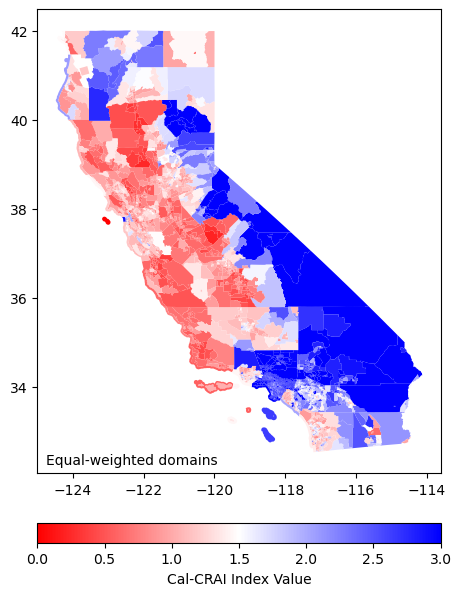

In [16]:
index_plot(calcrai_index_equal_weight, column='calcrai_score', vmin=0, vmax=3)

In [17]:
calcrai_index_equal_weight

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,climate_risk,calcrai_equal_weighted,calcrai_score
0,06001400100,0.651308,0.605062,0.518637,0.833488,0.642475,0.451652,0.748805,0.148310,0.113091,-0.058232,0.753671,0.783633,1.039755
1,06001400200,0.651308,0.553534,0.366578,0.841855,0.642475,0.451652,0.748805,-0.188363,0.124264,-0.138434,0.704640,0.519397,0.737109
2,06001400300,0.651308,0.557473,0.338360,0.793298,0.642475,0.451652,0.748805,-0.250839,0.059419,-0.132304,0.764024,0.440464,0.576506
3,06001400400,0.651308,0.549355,0.358216,0.770451,0.642475,0.451652,0.748805,-0.206877,0.028908,-0.144939,0.702309,0.440995,0.627922
4,06001400500,0.651308,0.552923,0.367882,0.744977,0.642475,0.451652,0.748805,-0.185476,-0.005111,-0.139386,0.781995,0.436394,0.558052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342,0.642475,0.451652,0.748805,0.044468,0.046124,-0.270099,0.409434,0.559693,1.366992
9125,06115041001,0.682143,0.416459,0.466137,0.742681,0.642475,0.451652,0.748805,0.032071,-0.008179,-0.351789,0.382023,0.458470,1.200112
9126,06115041002,0.682143,0.432561,0.584687,0.766956,0.642475,0.451652,0.748805,0.294550,0.024240,-0.326726,0.396227,0.676730,1.707934
9127,06115041101,0.682143,0.391202,0.683639,0.736324,0.642475,0.451652,0.748805,0.513641,-0.016668,-0.391102,0.361174,0.754363,2.088640


Number of invalid geometries: 0


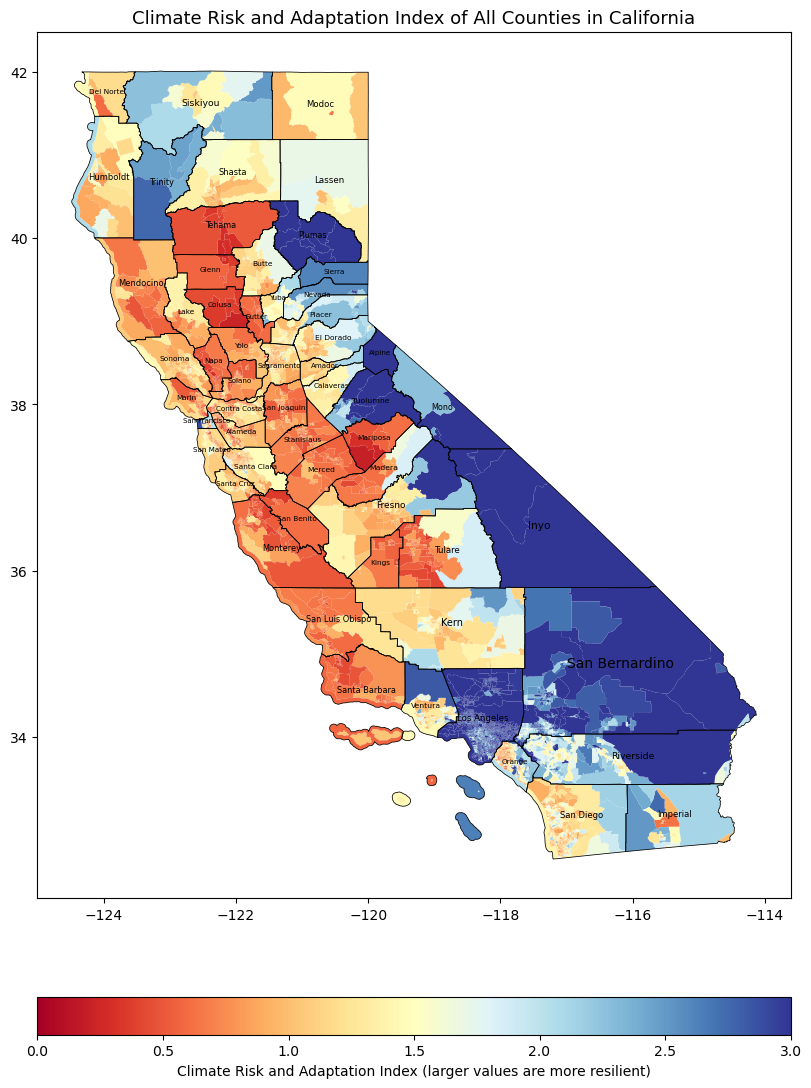

In [18]:
plot_region_domain(calcrai_index_equal_weight, counties_to_plot=None,
                   plot_all=True, savefig=False, font_color='black', domain='',
                   domain_label_map=None, vmin=0, vmax=3, column_to_plot='calcrai_score',cmap='RdYlBu',
                   intro_title='Climate Risk and Adaptation Index')

Number of invalid geometries: 0


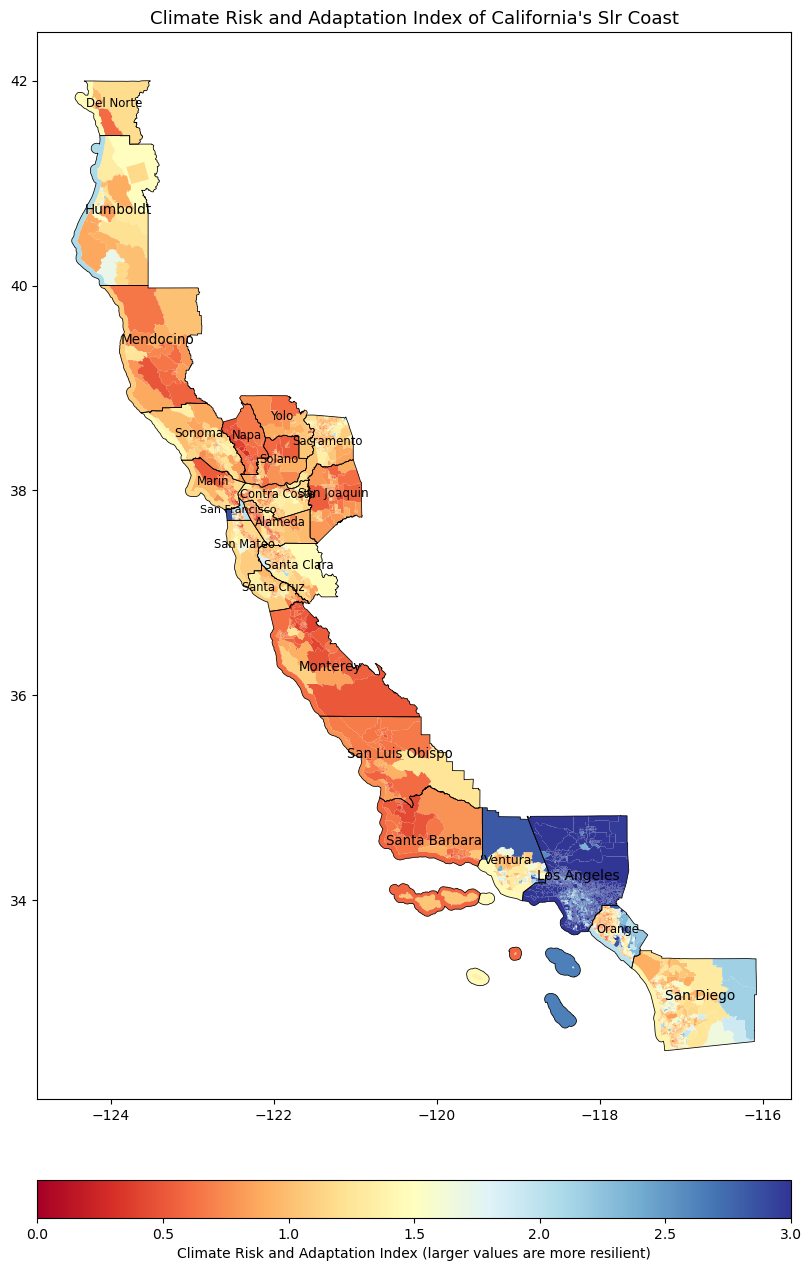

In [19]:
plot_region_domain(calcrai_index_equal_weight, counties_to_plot=None, region='slr_coast',
                   plot_all=False, savefig=False, font_color='black', domain='',
                   domain_label_map=None, vmin=0, vmax=3, column_to_plot='calcrai_score',cmap='RdYlBu',
                   intro_title='Climate Risk and Adaptation Index')

## 4) Bin the equal-weighted index score into 5 quartiles & visualize

In [20]:
# Binning into quartiles
binned_equal_df = calcrai_index_equal_weight.copy()

# Define the columns to bin
columns_to_bin = [
    'calcrai_score'
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_equal_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_equal_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_equal_df = binned_equal_df[['GEOID','calcrai_score_quartile']]
binned_equal_df

Bin edges for calcrai_score: [0.         0.85277929 1.13576607 1.66648434 2.76623607 7.82871681]


,GEOID,calcrai_score_quartile
0,06001400100,1
1,06001400200,0
2,06001400300,0
3,06001400400,0
4,06001400500,0
...,...,...
9124,06115040902,2
9125,06115041001,2
9126,06115041002,3
9127,06115041101,3


In [21]:
# Create a copy and chain the .replace() calls
binned_df_viz = binned_equal_df.copy()
binned_df_viz['calcrai_score_quartile'] = (
    binned_df_viz['calcrai_score_quartile']
    .replace(0, '0-20%')
    .replace(1, '20-40%')
    .replace(2, '40-60%')
    .replace(3, '60-80%')
    .replace(4, '80+%')
)
binned_df_viz.head()

,GEOID,calcrai_score_quartile
0,06001400100,20-40%
1,06001400200,0-20%
2,06001400300,0-20%
3,06001400400,0-20%
4,06001400500,0-20%


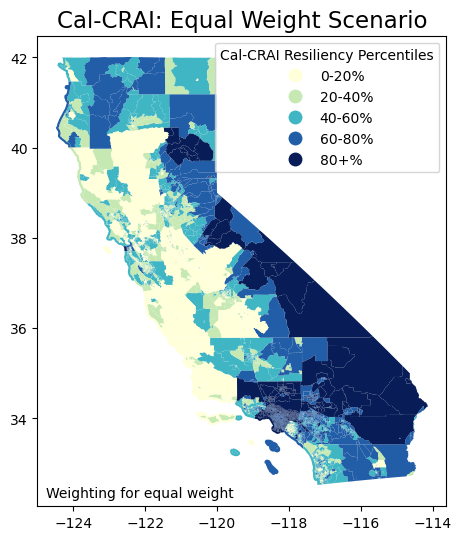

In [23]:
# List of binned columns
binned_columns = [
    'calcrai_score_quartile'
]

# Loop through each binned column and plot
for column in binned_columns:
    scenario_name = 'equal weight'

    index_plot(binned_df_viz, column, save_name=f'binned {scenario_name}', scenario=scenario_name, plot_title=True, vmin=0, vmax=5, plot_type='discrete')

# Step 5) Export as a GeoDataBase

### Merge with census tract and geometry boundaries before exporting to geodatabase

In [25]:
equal_weight_merged = add_census_tracts(calcrai_index_equal_weight)

In [54]:
# Create geometry column
geometry = [Point(xy) for xy in zip(equal_weight_merged['INTPTLON'], equal_weight_merged['INTPTLAT'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(equal_weight_merged, geometry=geometry, crs="EPSG:4269")  # Specify CRS

# Define the output path
gdb_path = r'../index_method/equal_weight_CRI.gdb'
gdb_path = r'C:/Users/jespi/eagle/carb-climate-index-10/scripts/index_method/equal_weight_CRI.gdb'

# Save to geodatabase
gdf.to_file(gdb_path, layer="cal_climate_resilience_adaptation_index", driver="OpenFileGDB")


### Zip gdb file for AWS upload

In [ ]:
# Path to the geodatabase directory
gdb_path = '../index_method/equal_weight_CRI.gdb'
gdb_path = r'C:/Users/jespi/eagle/carb-climate-index-10/scripts/index_method/equal_weight_CRI.gdb'

# Path for the zipped file
zip_path = 'equal_weight_CRI.zip'

# Create a zip archive of the geodatabase
shutil.make_archive('equal_weight_CRI', 'zip', gdb_path)

print(f"Geodatabase zipped at {zip_path}")


Geodatabase zipped at equal_weight_CRI.zip


In [56]:
# AWS bucket and directory
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

# File to upload (the zipped file)
file = 'equal_weight_CRI.zip'

# Use the existing function to upload
upload_csv_aws([file], bucket_name, directory)


equal_weight_CRI.zip uploaded to AWS
